In [2]:
import os
import io
from snowflake import connector
import numpy as np
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import pdb

USER = os.environ.get('SF_USERNAME')
PASSWORD = os.environ.get('SF_PASSWORD')
ACCOUNT = os.environ.get('SF_ACCOUNT')
WAREHOUSE = os.environ.get('SF_WAREHOUSE')
DATABASE = os.environ.get('SF_DATABASE')
SCHEMA = os.environ.get('SF_SCHEMA')
ROLE = os.environ.get('SF_ROLE')

conn = connector.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA
)

cur = conn.cursor()
s3 = boto3.resource(
        's3',
        aws_access_key_id=os.environ.get('AWS_ACCESS_KEY'),
        aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY')
    )

def get_query_results(query):
    cur.execute(query)
    df_query = cur.fetch_pandas_all()
    return df_query


### Lung dataset

### Get channel/cycle for each biomarker

In [41]:
query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=259 and VERSION=2 and DS='2022-03-03' and CELL_ID=1040
"""
df = get_query_results(query)

bm_map = {}
bm_map['DAPI'] = {'cycle': 2, 'channel': 1}
for bm in df['BIOMARKER_NAME'].unique():
    if bm == 'Empty' or bm == 'Blank' or bm == 'DAPI': continue
    channel = df[df['BIOMARKER_NAME'] == bm]['CHANNEL'].values[0]
    cycle = df[df['BIOMARKER_NAME'] == bm]['CYCLE'].values[0]
    bm_map[bm] = {'channel': int(channel), 'cycle': int(cycle)}
    
with open('/home/ubuntu/efs/dapi/data/lung_7plex_map.json', 'w') as outfile:
    json.dump(bm_map, outfile)

query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=293 and VERSION=2 and DS='2022-03-03' and CELL_ID=1040
"""
df = get_query_results(query)

bm_map = {}
bm_map['DAPI'] = {'cycle': 2, 'channel': 1}
for bm in df['BIOMARKER_NAME'].unique():
    if bm == 'Empty' or bm == 'Blank' or bm == 'DAPI': continue
    channel = df[df['BIOMARKER_NAME'] == bm]['CHANNEL'].values[0]
    cycle = df[df['BIOMARKER_NAME'] == bm]['CYCLE'].values[0]
    bm_map[bm] = {'channel': int(channel), 'cycle': int(cycle)}
    
with open('/home/ubuntu/efs/dapi/data/lung_codex_map.json', 'w') as outfile:
    json.dump(bm_map, outfile)

In [42]:
query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=259 and VERSION=2 and DS='2022-03-03' and BIOMARKER_NAME != 'Blank' and BIOMARKER_NAME != 'Empty'
"""
df = get_query_results(query)
df.to_parquet('dfs/Lung_7plex/exp_df_from_sql.pqt')

# SAVE ACQUISITION IDs

acq_ids = df['ACQUISITION_ID'].unique()
np.save('/home/ubuntu/efs/dapi/data/lung_7plex_acq_ids.npy', list(acq_ids))

query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=293 and VERSION=2 and DS='2022-03-03' and BIOMARKER_NAME != 'Blank' and BIOMARKER_NAME != 'Empty'
"""
df = get_query_results(query)
df.to_parquet('dfs/Lung_codex/exp_df_from_sql.pqt')

# SAVE ACQUISITION IDs

acq_ids = df['ACQUISITION_ID'].unique()
np.save('/home/ubuntu/efs/dapi/data/lung_codex_acq_ids.npy', list(acq_ids))

In [22]:
acq_ids_7plex = np.load('/home/ubuntu/efs/dapi/data/lung_7plex_acq_ids.npy')

In [ ]:
acq_ids_codex = np.load('/home/ubuntu/efs/dapi/data/lung_codex_acq_ids.npy')
acq_ids_codex

In [43]:
df = pd.read_parquet('dfs/Lung_7plex/exp_df_from_sql.pqt')
df_ = df.reset_index().groupby(['CELL_ID', 'ACQUISITION_ID', 'BIOMARKER_NAME'])['VALUE'].first().unstack(level=-1)
df_.columns = df_.columns.to_flat_index()
df_ = df_.reset_index()
df_.columns.set_names(None, inplace=True)
df_ = df_.sort_values(by=['CELL_ID', 'ACQUISITION_ID'])

# set DAPI to second cycle first channel
df_['DAPI'] = df[(df['CHANNEL'] == 1) & (df['CYCLE'] == 2)][['CELL_ID', 'ACQUISITION_ID', 'VALUE']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])['VALUE'].values
df_.to_parquet('dfs/Lung_7plex/raw_exp_df.pqt')

df = pd.read_parquet('dfs/Lung_codex/exp_df_from_sql.pqt')
df_ = df.reset_index().groupby(['CELL_ID', 'ACQUISITION_ID', 'BIOMARKER_NAME'])['VALUE'].first().unstack(level=-1)
df_.columns = df_.columns.to_flat_index()
df_ = df_.reset_index()
df_.columns.set_names(None, inplace=True)
df_ = df_.sort_values(by=['CELL_ID', 'ACQUISITION_ID'])

# set DAPI to second cycle first channel
df_['DAPI'] = df[(df['CHANNEL'] == 1) & (df['CYCLE'] == 2)][['CELL_ID', 'ACQUISITION_ID', 'VALUE']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])['VALUE'].values
df_.to_parquet('dfs/Lung_codex/raw_exp_df.pqt')

In [53]:
def alex_norm(x):
    import scipy.stats as stats
    factor = np.quantile(x, 0.2)*5
    factor = factor if factor != 0 else 1
    x = stats.zscore(np.arcsinh(x/factor))

    return x


alex_exp_df = pd.read_parquet('dfs/Lung_7plex/raw_exp_df.pqt')
biomarkers = ['CD68', 'CD8', 'DAPI', 'FoxP3', 'PD1', 'PDL1', 'PanCK']

df_ = alex_exp_df.copy()
for acq_id, rows in df_.groupby('ACQUISITION_ID'):
    for biomarker in biomarkers:
        if any(np.isnan(rows[biomarker])):
            print(rows[biomarker])
            raise ValueError()
        alex_exp_df.loc[rows.index, biomarker] = alex_norm(rows[biomarker])
        
alex_exp_df['COVERSLIP_ID'] = alex_exp_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

alex_exp_df.to_parquet('dfs/Lung_7plex/alex_norm_exp_df.pqt')



alex_exp_df = pd.read_parquet('dfs/Lung_codex/raw_exp_df.pqt')
biomarkers = ['CD107a', 'CD117', 'CD11b', 'CD11c',
       'CD14', 'CD141', 'CD15', 'CD163', 'CD183', 'CD197', 'CD20', 'CD21',
       'CD25', 'CD31', 'CD34', 'CD38', 'CD3e', 'CD4', 'CD44', 'CD45', 'CD45RA',
       'CD45RO', 'CD56', 'CD68', 'CD8', 'DAPI', 'FoxP3', 'GranzymeB', 'HLA-DR',
       'Ki67', 'PGP9.5', 'PanCK', 'Podoplanin', 'RORgammaT', 'SPP1', 'Siglec8',
       'Vimentin']
df_ = alex_exp_df.copy()
for acq_id, rows in df_.groupby('ACQUISITION_ID'):
    for biomarker in biomarkers:
        if any(np.isnan(rows[biomarker])):
            print(rows[biomarker])
            raise ValueError()
        alex_exp_df.loc[rows.index, biomarker] = alex_norm(rows[biomarker])
        
alex_exp_df['COVERSLIP_ID'] = alex_exp_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

alex_exp_df.to_parquet('dfs/Lung_codex/alex_norm_exp_df.pqt')

### Get cell labels

In [ ]:
query = """
select distinct a.CELL_ID, a.ACQUISITION_ID, b.ANNOTATION_LABEL 
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATIONS a 
inner join ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATION_CLASS_LABELS as b
on a.VALUE = b.ANNOTATION_VALUE
where a.ANNOTATION_ID=94 and b.ANNOTATION_ID=94 and a.DS='2022-03-03'"""
df = get_query_results(query)
data_df = df[['CELL_ID', 'ACQUISITION_ID', 'ANNOTATION_LABEL']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])
data_df['LABEL_NAME'] = data_df.ANNOTATION_LABEL.apply(lambda x: x.split('(')[0])
labels = list(data_df['LABEL_NAME'].unique())
data_df['LABEL'] = data_df['LABEL_NAME'].apply(lambda x: labels.index(x))
data_df['PATH'] = data_df.apply(lambda row: '/data/segs/{}/{}/version_{}/'+row['ACQUISITION_ID']+'/{:03d}'.format(row['CELL_ID'])+'.png', axis=1)
data_df['COVERSLIP_ID'] = data_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

data_df.to_parquet('dfs/Lung_codex/data_df_v0.pqt')
!chmod 0400 dfs/Lung_codex/data_df_v0.pqt

In [38]:
query = """
select distinct a.CELL_ID, a.ACQUISITION_ID, b.ANNOTATION_LABEL 
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATIONS a 
inner join ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATION_CLASS_LABELS as b
on a.VALUE = b.ANNOTATION_VALUE
where a.ANNOTATION_ID=94 and b.ANNOTATION_ID=94 and a.DS='2022-03-03'"""
df = get_query_results(query)
data_df = df[['CELL_ID', 'ACQUISITION_ID', 'ANNOTATION_LABEL']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])
data_df['LABEL_NAME'] = data_df.ANNOTATION_LABEL.apply(lambda x: x.split('(')[0])
labels = list(data_df['LABEL_NAME'].unique())
data_df['LABEL'] = data_df['LABEL_NAME'].apply(lambda x: labels.index(x))
data_df['PATH'] = data_df.apply(lambda row: '/data/segs/{}/{}/version_{}/'+row['ACQUISITION_ID']+'/{:03d}'.format(row['CELL_ID'])+'.png', axis=1)
data_df['COVERSLIP_ID'] = data_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

data_df.to_parquet('dfs/Lung_7plex/data_df_v0.pqt')
!chmod 0400 dfs/Lung_7plex/data_df_v0.pqt

In [5]:
!sudo mkdir /home/ubuntu/efs/dapi/resnet/dfs/version_23/
!sudo cp dfs/Lung_7plex/data_df_v0.pqt /home/ubuntu/efs/dapi/resnet/dfs/version_23/data_df.pqt
!sudo chmod 0400 /home/ubuntu/efs/dapi/resnet/dfs/version_23/data_df.pqt

### Get coordinates

In [4]:
query = """select DISTINCT 
CELL_ID,
X,
Y
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_SEGMENTATION_OUTPUT
where 
DS='2022-03-03' and STUDY_ID=259 and VERSION=2
"""
df = get_query_results(query)
df.to_parquet('dfs/Lung_7plex/cell_xy.pqt')

query = """select DISTINCT 
CELL_ID,
X,
Y
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_SEGMENTATION_OUTPUT
where 
DS='2022-03-03' and STUDY_ID=293 and VERSION=2
"""
df = get_query_results(query)
df.to_parquet('dfs/Lung_codex/cell_xy.pqt')

## CellSight processing

### First, find the channel/cycle for each biomarker

In [ ]:
query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=251 and VERSION=5 and DS='2021-12-09' and CELL_ID=17940 and ACQUISITION_ID='CellSight_c001_v001_r001_reg010'
"""
df = get_query_results(query)

bm_map = {}
bm_map['DAPI'] = {'cycle': 2, 'channel': 1}
for bm in df['BIOMARKER_NAME'].unique():
    if bm == 'Empty' or bm == 'Blank' or bm == 'DAPI': continue
    channel = df[df['BIOMARKER_NAME'] == bm]['CHANNEL'].values[0]
    cycle = df[df['BIOMARKER_NAME'] == bm]['CYCLE'].values[0]
    bm_map[bm] = {'channel': int(channel), 'cycle': int(cycle)}
    
with open('/home/ubuntu/efs/dapi/data/cellsight_map.json', 'w') as outfile:
    json.dump(bm_map, outfile)

### Next, download all expression data

In [25]:
query = """
select * from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_BIOMARKER_EXPRESSIONS where STUDY_ID=251 and VERSION=5 and DS='2021-12-09' and BIOMARKER_NAME != 'Blank' and BIOMARKER_NAME != 'Empty'
"""
df = get_query_results(query)
df.to_parquet('dfs/CellSight/exp_df_from_sql.pqt')

In [41]:
# SAVE ACQUISITION IDs

acq_ids = df['ACQUISITION_ID'].unique()
np.save('/home/ubuntu/efs/dapi/data/cellsight_acq_ids.npy', list(acq_ids))

In [ ]:
df = pd.read_parquet('dfs/CellSight/exp_df_from_sql.pqt')
biomarkers = list(df['BIOMARKER_NAME'].unique())
biomarkers.remove('ICOS')

In [97]:
df_ = df.reset_index().groupby(['CELL_ID', 'ACQUISITION_ID', 'BIOMARKER_NAME'])['VALUE'].first().unstack(level=-1)
df_.columns = df_.columns.to_flat_index()
df_ = df_.reset_index()
df_.columns.set_names(None, inplace=True)
df_ = df_.sort_values(by=['CELL_ID', 'ACQUISITION_ID'])

# set DAPI to second cycle first channel
df_['DAPI'] = df[(df['CHANNEL'] == 1) & (df['CYCLE'] == 2)][['CELL_ID', 'ACQUISITION_ID', 'VALUE']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])['VALUE'].values
df_.to_parquet('dfs/CellSight/raw_exp_df.pqt')

### Now, apply Alex norm to expression values

In [3]:
alex_exp_df = pd.read_parquet('dfs/CellSight/raw_exp_df.pqt')


In [4]:
alex_exp_df

CELL_ID                   ACQUISITION_ID       CD107a       CD117  \
0              1  CellSight_c001_v001_r001_reg001  2339.626953  137.419006   
1              1  CellSight_c001_v001_r001_reg002   718.143005  206.845993   
2              1  CellSight_c001_v001_r001_reg003    65.316002   57.391998   
3              1  CellSight_c001_v001_r001_reg004    72.179001   37.834000   
4              1  CellSight_c001_v001_r001_reg005   597.122009   86.462997   
...          ...                              ...          ...         ...   
1643486   116050  CellSight_c006_v001_r001_reg007   800.091980   81.510002   
1643487   116051  CellSight_c006_v001_r001_reg007  1282.342041   73.557999   
1643488   116052  CellSight_c006_v001_r001_reg007   801.145996  174.744003   
1643489   116053  CellSight_c006_v001_r001_reg007   709.882996  110.883003   
1643490   116054  CellSight_c006_v001_r001_reg007   801.445007  626.291016   

               CD11b       CD11c      CD134         CD14         CD15  \
0         103.000000  153.242004  67.126999  4200.390137   374.037994   
1         207.845993  121.593002  53.352001  3785.889893   366.274994   
2          27.082001   45.032001  30.184000   242.576004    83.411003   
3          17.344000   51.603001  38.518002   590.122986  1316.495972   
4          49.146000  139.341003  64.841003  2978.219971   264.695007   
...              ...         ...        ...          ...          ...   
1643486   216.778000   87.698997  42.490002   693.836975    48.189999   
1643487   180.000000  130.324997  39.807999   683.107971    30.125000   
1643488   631.914978  108.462997  42.279999  1960.732056    43.438999   
1643489   216.524994   95.817001  37.750000   956.317017    32.200001   
1643490  3033.063965  731.854980  44.808998   514.335999    38.473000   

               CD197  ...          PD1       PDL1      PGP9.5        PanCK  \
0         518.424011  ...   400.750000  52.321999  102.716003    58.886002   
1        1003.252991  ...  1066.021973  81.736000   54.439999  1210.681030   
2          26.690001  ...   210.285004  63.056999   24.632999    30.222000   
3          41.567001  ...   339.696014  67.386002   32.682999    47.682999   
4          91.512001  ...   474.720001  68.329002   32.682999   333.720001   
...              ...  ...          ...        ...         ...          ...   
1643486   410.365997  ...    32.222000  52.051998   46.306999   102.124001   
1643487   416.333008  ...    43.033001  37.567001   39.150002   102.983002   
1643488   237.598007  ...    44.951000  19.561001   39.231998   158.792999   
1643489   301.899994  ...   101.150002  44.341999   30.600000   179.257996   
1643490  3227.254883  ...    61.209000  50.799999   68.291000  1228.582031   

          Podoplanin         TFAM    TMEM16A     Vimentin        aSMA  \
0         704.185974   381.648010  95.347000  3562.339111   60.483002   
1        2901.374023  1212.010986  81.681000   622.109985   65.440002   
2         643.822998    45.334999  60.619999    56.626999   38.816002   
3          43.598000   450.595001  44.859001    45.460999   49.259998   
4        1563.378052   129.682999  45.659000    96.439003   35.768002   
...              ...          ...        ...          ...         ...   
1643486   452.902008   325.673004  38.640999   258.320007   82.882004   
1643487  1346.574951   408.183014  22.833000   203.050003   70.400002   
1643488   492.316986   295.670990  32.073002   206.000000  106.877998   
1643489   141.367004   174.774994  26.450001   143.274994  151.975006   
1643490  2404.864014  1565.727051  29.009001    30.872999  581.609009   

                p16  
0         26.542000  
1         67.264000  
2         43.747002  
3         32.675999  
4         50.036999  
...             ...  
1643486   56.693001  
1643487   89.083000  
1643488   91.084999  
1643489   57.932999  
1643490  383.463989  

[1643491 rows x 42 columns]

In [15]:
def alex_norm(x):
    factor = np.quantile(x, 0.2)*5
    factor = factor if factor != 0 else 1
    x = stats.zscore(np.arcsinh(x/factor))

    return x

alex_exp_df = pd.read_parquet('dfs/CellSight/raw_exp_df.pqt')
df_ = alex_exp_df.copy()
for acq_id, rows in df_.groupby('ACQUISITION_ID'):
    for biomarker in biomarkers:
        if any(np.isnan(rows[biomarker])):
            print(rows[biomarker])
            raise ValueError()
        alex_exp_df.loc[rows.index, biomarker] = alex_norm(rows[biomarker])

In [16]:
alex_exp_df['COVERSLIP_ID'] = alex_exp_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

In [17]:
alex_exp_df.to_parquet('dfs/CellSight/alex_norm_exp_df.pqt')

## Finally, get the cell type labels and data DF

In [37]:
query = """
select distinct a.CELL_ID, a.ACQUISITION_ID, b.ANNOTATION_LABEL 
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATIONS a 
inner join ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_ANNOTATION_CLASS_LABELS as b
on a.VALUE = b.ANNOTATION_VALUE
where a.ANNOTATION_ID=114 and b.ANNOTATION_ID=114 and a.DS='2021-12-13'"""
df = get_query_results(query)


In [38]:
data_df = df[['CELL_ID', 'ACQUISITION_ID', 'ANNOTATION_LABEL']].sort_values(by=['CELL_ID', 'ACQUISITION_ID'])
data_df['LABEL_NAME'] = data_df.ANNOTATION_LABEL.apply(lambda x: x.split('(')[0])
labels = list(data_df['LABEL_NAME'].unique())
data_df['LABEL'] = data_df['LABEL_NAME'].apply(lambda x: labels.index(x))
data_df['PATH'] = data_df.apply(lambda row: '/data/segs/{}/{}/version_{}/'+row['ACQUISITION_ID']+'/{:03d}'.format(row['CELL_ID'])+'.png', axis=1)
data_df['COVERSLIP_ID'] = data_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])

data_df.to_parquet('dfs/CellSight/data_df_v0.pqt')
!chmod 0400 dfs/CellSight/data_df_v0.pqt

In [41]:
!sudo mkdir /home/ubuntu/efs/dapi/resnet/dfs/version_21/
!sudo cp dfs/CellSight/data_df_v0.pqt /home/ubuntu/efs/dapi/resnet/dfs/version_21/data_df.pqt
!sudo chmod 0400 /home/ubuntu/efs/dapi/resnet/dfs/version_21/data_df.pqt

mkdir: cannot create directory ‘/home/ubuntu/efs/dapi/resnet/dfs/version_21/’: File exists


## UPMC processing

In [3]:
query = """select DISTINCT 
CELL_ID,
X,
Y
from ZOU_LAB_DATA_EXPORT.CORE_DATA.CELL_SEGMENTATION_OUTPUT
where 
DS='2021-07-25' and 
VERSION='5'
"""
df = get_query_results(query)


In [5]:
df.to_parquet('dfs/UPMC/cell_xy.pqt')

### Comparing cell type prediction versions

In [2]:
upmc_cell_labels = get_labels('upmc')

In [21]:
c003_df = pd.read_csv('export/upmc_celltype_preds_c003_1129.csv')
c005_df = pd.read_csv('export/upmc_celltype_preds_c005_1129.csv')
#c005_df['PRED'] = c005_df['PRED'].apply(lambda x: upmc_cell_labels.index(x))

In [22]:
ref_test_df = pd.read_csv('~/efs/dapi/notebooks/data/michael_test_preds.csv')
ref_val_df = pd.read_csv('~/efs/dapi/notebooks/data/michael_val_preds.csv')
ref_test_df['pred'] = ref_test_df['pred'].apply(lambda x: upmc_cell_labels.index(x))
ref_val_df['pred'] = ref_val_df['pred'].apply(lambda x: upmc_cell_labels.index(x))


In [26]:
df_ = c005_df.merge(ref_test_df, on='CELL_ID')[['PRED', 'pred']]
# df_ = c003_df.merge(ref_val_df, on='CELL_ID')[['PRED', 'pred']]

<AxesSubplot:>

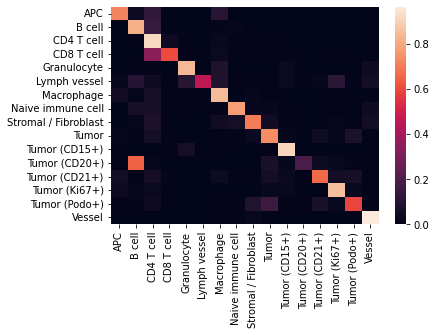

In [27]:
cm = confusion_matrix(df_['PRED'], df_['pred'], normalize='true')
sns.heatmap(cm, xticklabels=upmc_cell_labels, yticklabels=upmc_cell_labels)


### Generate "annotated gt" training DF

In [2]:
cell_exp_df = pd.read_parquet('dfs/UPMC/alex_norm_exp_df.pqt')
train_df = cell_exp_df.sample(64000)
train_df.to_parquet('dfs/UPMC/annotated_train_df.pqt')

### Save expression df (Alex norm)

In [60]:
cell_exp_df = pd.read_csv('data_raw/UPMC/Expression_Matrix_Asinh-Zscale_full-features.tsv', delimiter='\t', engine='c', memory_map=True, low_memory=False)
cell_exp_dapi_df = pd.read_csv('data_raw/UPMC/Expression_Matrix_Asinh-Zscale_Background.tsv', delimiter='\t', engine='c', memory_map=True, low_memory=False)
temp_df = cell_exp_df.T
temp_df['DAPI'] = cell_exp_dapi_df.T['DAPI']
temp_df = temp_df.reset_index()#.rename(columns={'index': 'CELL_ID'})
temp_df['CELL_ID'] = temp_df['index'].apply(lambda x: x.split('_')[-1]).astype(int)
temp_df['ACQUISITION_ID'] = temp_df['index'].apply(lambda x: '_'.join(x.split('_')[:-1]))
temp_df = temp_df.drop(columns=['index'])
temp_df.to_parquet('dfs/UPMC/alex_norm_exp_df.pqt')

In [61]:
!chmod 0400 dfs/UPMC/alex_norm_exp_df.pqt

### Save training DFs

In [17]:
label_df = pd.read_csv('data_raw/UPMC/Cluster_Labels_New.txt', delimiter='\t', engine='c', memory_map=True, low_memory=False)
label_df['CELL_ID'] = label_df['cell.id'].apply(lambda x: x.split('_')[-1]).astype(int)
temp_df = pd.read_parquet('dfs/UPMC/alex_norm_exp_df.pqt')
temp_w_labels_df = temp_df.merge(label_df[['CELL_ID', 'Cell.type']], on='CELL_ID')
temp_w_labels_df = temp_w_labels_df.rename(columns={'Cell.type': 'LABEL_NAME'})
cell_labels = list(np.sort(temp_w_labels_df['LABEL_NAME'].unique()))
temp_w_labels_df['LABEL'] = temp_w_labels_df['LABEL_NAME'].apply(lambda x: cell_labels.index(x))
temp_w_labels_df['PATH'] = temp_w_labels_df.apply(lambda row: '/data/segs/{}/{}/version_{}/'+'{}/{}.png'.format(row['ACQUISITION_ID'], row['CELL_ID']), axis=1)
temp_w_labels_df['split'] = temp_w_labels_df['ACQUISITION_ID'].apply(lambda x: 'valid' if 'c003' in x else 'test' if 'c005' in x else 'train')
temp_w_labels_df.to_parquet('dfs/UPMC/data_df_v0.pqt')
!chmod 0400 dfs/UPMC/data_df_v0.pqt

## Charville processing

### Save expression df (Alex norm)

In [62]:
exp_df = pd.read_csv('data_raw/Charville/Charville_Scaled_Biomarker_Expression.csv', engine='c', memory_map=True, low_memory=False)
new_exp_df = exp_df.T.reset_index()
new_exp_df = new_exp_df.rename(columns={'index': 'CELL_ID'})

# Get DAPI values as well
dataset_dict = get_dataset_dict()
biomarker = 'DAPI'
channel = dataset_dict['charville']['biomarker_map'][biomarker]['channel']
cycle = dataset_dict['charville']['biomarker_map'][biomarker]['cycle']

def alex_norm(x):
    factor = np.quantile(x, 0.2)*5
    factor = factor if factor != 0 else 1
    x = stats.zscore(np.arcsinh(x/factor))
    return x

df_ = get_exp_from_study_id(242, version=6, cycle=cycle, channel=channel)
dapi_df = df_[['CELL_ID', 'VALUE', 'ACQUISITION_ID']]
dapi_df['CELL_ID'] = dapi_df.apply(lambda row: row['ACQUISITION_ID']+'_'+str(row['CELL_ID']), axis=1)
for acq_id, rows in dapi_df.groupby('ACQUISITION_ID'):
    dapi_df.loc[rows.index, biomarker] = alex_norm(rows['VALUE'])
new_exp_df = new_exp_df.merge(dapi_df[['CELL_ID', biomarker]], on='CELL_ID')

new_exp_df.to_parquet('dfs/Charville/alex_norm_exp_df.pqt')

In [63]:
!chmod 0400 dfs/Charville/alex_norm_exp_df.pqt

### Save manually annotated training data

In [2]:
### PROCESS CHARVILLE KNN TRAINING DATA ###

df1 = pd.read_csv('data_raw/Charville/Charville_Training_Data.csv')
df2 = pd.read_csv('data_raw/Charville/Charville_Training_Classes.csv')
df2 = df2.reset_index()['x']
df1 = df1.reset_index()
df = df1.join(df2)
df = df.rename(columns={'index': 'CELL_ID', 'x': 'LABEL_NAME'})
labels = list(np.sort(df['LABEL_NAME'].unique()))
df['LABEL'] = df['LABEL_NAME'].apply(lambda x: labels.index(x))
df.to_parquet('dfs/Charville/annotated_train_df.pqt')

In [3]:
!chmod 0400 dfs/Charville/annotated_train_df.pqt

### Save training DFs

In [100]:
label_df = pd.read_csv('data_raw/Charville/KNN-derived_full_cell_classifications.csv', engine='c', memory_map=True, low_memory=False)
label_df = label_df.rename(columns={'cell.id': 'CELL_ID', 'Cell.subtype': 'LABEL_NAME'})
new_exp_df = pd.read_parquet('dfs/Charville/alex_norm_exp_df.pqt')
temp_w_labels_df = new_exp_df.merge(label_df, on='CELL_ID')
cell_labels = list(np.sort(temp_w_labels_df['LABEL_NAME'].unique()))
temp_w_labels_df['LABEL'] = temp_w_labels_df['LABEL_NAME'].apply(lambda x: cell_labels.index(x))
temp_w_labels_df['ACQUISITION_ID'] = temp_w_labels_df['CELL_ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
temp_w_labels_df['PATH'] = temp_w_labels_df.apply(lambda row: '/data/segs/{}/{}/version_{}/'+row['ACQUISITION_ID']+'/{:03d}'.format(int(row['CELL_ID'].split('_')[-1]))+'.png', axis=1)

temp_w_labels_df['COVERSLIP_ID'] = temp_w_labels_df['ACQUISITION_ID'].apply(lambda x: x.split('_')[1])
temp_w_labels_df['split'] = 'testval'
temp_w_labels_df.loc[temp_w_labels_df['COVERSLIP_ID'].isin(['c001','c002','c003']), 'split'] = 'train'

test_val_df = temp_w_labels_df[temp_w_labels_df['split'] == 'testval']
acq_ids = test_val_df['ACQUISITION_ID'].unique()
np.random.shuffle(acq_ids)
valid_ids, test_ids = acq_ids[0:len(acq_ids)//2], acq_ids[len(acq_ids)//2:]
temp_w_labels_df.loc[temp_w_labels_df['ACQUISITION_ID'].isin(valid_ids), 'split'] = 'valid'
temp_w_labels_df.loc[temp_w_labels_df['ACQUISITION_ID'].isin(test_ids), 'split'] = 'test'

temp_w_labels_df.to_parquet('dfs/Charville/data_df_v0.pqt')
!chmod 0400 dfs/Charville/data_df_v0.pqt

In [1]:
!sudo mkdir /home/ubuntu/efs/dapi/resnet/dfs/version_22/
!sudo cp dfs/Charville/data_df_v0.pqt /home/ubuntu/efs/dapi/resnet/dfs/version_22/data_df.pqt
!sudo chmod 0400 /home/ubuntu/efs/dapi/resnet/dfs/version_22/data_df.pqt


In [4]:
temp_w_labels_df = pd.read_parquet('dfs/Charville/data_df_v0.pqt')


In [5]:
temp_w_labels_df['COVERSLIP_ID'].value_counts(normalize=True)

c003    0.345252
c001    0.248235
c002    0.210582
c004    0.195931
Name: COVERSLIP_ID, dtype: float64